# "emPPCA": &nbsp; A reconstruction perspective

In [1]:
# emPPCA package
import sys
sys.path.append('../')
from replicatePPCA import emPPCA

# Auxiliary packages
import copy
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from natsort import index_natsorted
from matplotlib.colors import Normalize

# Other packages for imputation
from nipals import nipals
from sklearn.impute import KNNImputer
from sklearn.cross_decomposition import PLSRegression
from statsmodels.multivariate.pca import PCA as statsmodels_pca

---

In this notebook we analyse the mean squared reconstruction errors (MSE) of the reconstruction compared to the original data. Notably, mass spectrometry proteomics data often suffers from missing measurements. The missing structures are further different across different replicates. Hence when researchers use visualization tools including principal component analysis (PCA), missing value imputation is inevitable.

Common imputation methods prior or accompanying PCA, as assessed in [1], include: 
- **Mean:** &nbsp; we will use `numpy.nanmean` for imputation 
- **Nipals:** &nbsp; Due to shortage of suitable Python functions, a function has been written in the separate file "nipals.py"
- **K-NN:** &nbsp; we will use `sklearn.impute.KNNImputer`, testing different values of K
- **JointM:** &nbsp; 
- **Ipca:** &nbsp; this applies EM algorithm with missing values as hidden variables. We will use `statsmodels.multivariate.pca` with specifying `missing='fill-em'`
- **PairCor:** &nbsp; 

We will compare these imputation methods along with `emPPCA`, benchmarking on the _tobomovirus_ dataset tested in [2].

In [2]:
# Dataframe loading, same as the process in "emPPCA examples"
virus = pd.read_csv('../datasets/tobomovirus/virus3.txt', delimiter='\s+', header=None).values
np.random.seed(123)
R = 4
name_rep = []
Y = []
perturb = []
scale = 3 / (R-1)
for r in range(R):
    perturb.append(np.random.normal(loc=0.0, scale=scale*r, size=virus.shape))
    current_rep = virus + perturb[r] # Add random perturbation
    mask = np.random.choice([True, False], size=virus.shape, p=[0.2, 0.8]) # Create mask for matrix entries
    current_rep = np.where(mask, np.nan, current_rep) # Set each entry missing at the probability of 20%
    Y.append(current_rep) # Append the current replicate to the list
Y_concat = np.concatenate(Y) # Haven't standardized
scaler_nan = StandardScaler()
Y_concat_std = scaler_nan.fit_transform(Y_concat) # Standardized Y_concat

# The reference for comparison (4 duplicates of the first replicate, with complete data)
reference = np.vstack([virus]*R) # Compare to full data without perturbation => cause larger MSE if there are more PCs
# reference = np.vstack([virus + perturb[r] for r in range(R)]) # Compare to full data with perturbation

In [3]:
def PCA_MSE(Y_imputed, reference, q=2):
    scaler_pca = StandardScaler()
    Y_imputed_std = scaler_pca.fit_transform(Y_imputed)
    pca = PCA(n_components=q)
    X_pca = pca.fit_transform(Y_imputed_std)
    recon = pca.inverse_transform(X_pca)
    recon = scaler_pca.inverse_transform(recon)
    MSE_pca = MSE(reference, recon)
    return MSE_pca

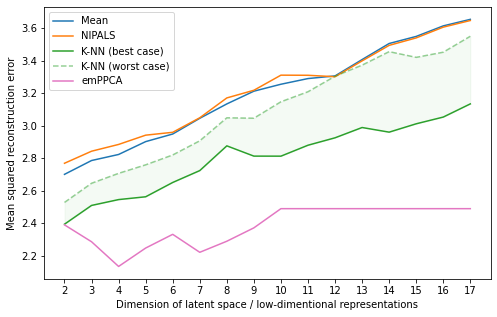

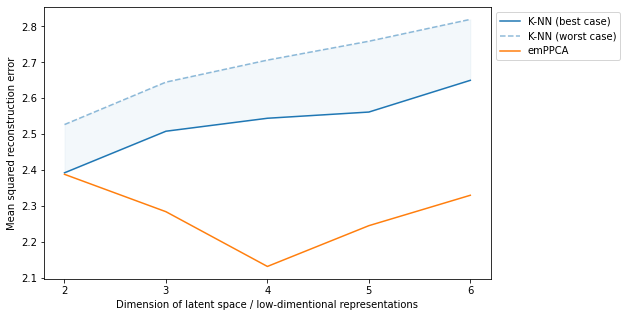

In [10]:
num_q = Y_concat.shape[1] - 2 # Number of distinct latent dimensions being visualized
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# MSE via Mean imputation, q = 2,...,17
nan_means = np.nanmean(Y_concat, axis=0)
missings = np.where(np.isnan(Y_concat))
Y_concat_meanimp = copy.deepcopy(Y_concat)
Y_concat_meanimp[missings] = np.take(nan_means, missings[1])
MSE_Mean = [PCA_MSE(Y_concat_meanimp, reference, q+2) for q in range(num_q)]
ax.plot(MSE_Mean, c=colors[0], label='Mean')

# MSE via NIPALS imputation, q = 2,...,17
# NIPALS is unable to impute before standardising as others do (so does emPPCA)
MSE_NIPALS = np.zeros(num_q)
for q in range(num_q):
    # nipals_pca = dict(zip(['trans', 'pc', 'recon', 'imp'], nipals(virus, n_components=q)))
    _, _, recon, _ = nipals(Y_concat_std, n_components=q+2)
    recon = scaler_nan.inverse_transform(recon)
    MSE_NIPALS[q] = MSE(reference, recon)
ax.plot(MSE_NIPALS, c=colors[1], label='NIPALS')


# MSE via K-NN imputation, q = 2,...,17, K = 1,...,38
MSE_KNN = [[] for q in range(num_q)]
MSE_KNN_min = np.zeros((2, num_q))
MSE_KNN_max = np.zeros((2, num_q))
for q in range(num_q):
    MSE_KNN[q] = [PCA_MSE(KNNImputer(n_neighbors=k+1).fit_transform(Y_concat), reference, q+2) for k in range(38)]
    MSE_KNN_min[:, q] = np.argmin(MSE_KNN[q]) + 2, np.min(MSE_KNN[q])
    MSE_KNN_max[:, q] = np.argmax(MSE_KNN[q]) + 2, np.max(MSE_KNN[q])
ax.plot(MSE_KNN_min[1, :], c=colors[2], label='K-NN (best case)')
ax.plot(MSE_KNN_max[1, :], '--', c=colors[2], label='K-NN (worst case)', alpha=0.5)
ax.fill_between(range(0, num_q), MSE_KNN_min[1, :], MSE_KNN_max[1, :], color=colors[2], alpha=0.05)

# Joint M

# Ipca

# PairCor


# MSE via "emPPCA" (with replicates) imputation, q = 2,...,17, K = 1,...,38
counter = 0
for r in range(R):
    Y[r] = Y_concat_std[counter:(counter+Y[r].shape[0]), :]
    counter += Y[r].shape[0]
MSE_emPPCA = [[] for q in range(num_q)]
for q in range(num_q):
    tobomovirus = emPPCA(Y, q+2)
    tobomovirus.fit(tol=1e-16, max_iter=2000, verbose=False)
    recon = scaler_nan.inverse_transform(np.concatenate(tobomovirus.recon))
    MSE_emPPCA[q] = MSE(reference, recon)
ax.plot(MSE_emPPCA, c=colors[6], label='emPPCA')


# Compare the MSEs
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.legend()
ax.set_xticks(range(0, num_q))
ax.set_xticklabels(range(2, 2+num_q))
ax.set_xlabel('Dimension of latent space / low-dimentional representations')
ax.set_ylabel('Mean squared reconstruction error')
plt.savefig('em_output_figures/recon_MSE.pdf')
plt.show()

# Closer look
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(MSE_KNN_min[1, :5], c=colors[0], label='K-NN (best case)')
ax.plot(MSE_KNN_max[1, :5], '--', c=colors[0], label='K-NN (worst case)', alpha=0.5)
ax.fill_between(range(0, 5), MSE_KNN_min[1, :5], MSE_KNN_max[1, :5], color=colors[0], alpha=0.05)
ax.plot(MSE_emPPCA[:5], c=colors[1], label='emPPCA')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticks(range(0, 5))
ax.set_xticklabels(range(2, 7))
ax.set_xlabel('Dimension of latent space / low-dimentional representations')
ax.set_ylabel('Mean squared reconstruction error')
plt.show()

An interesting plot of MSE, particularly for imputation via K-NN

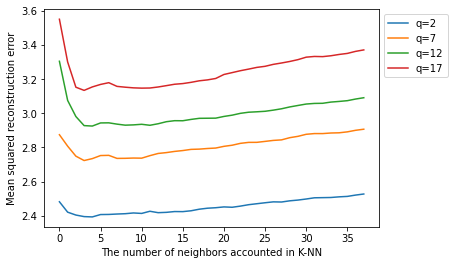

In [5]:
for i in range(0, len(MSE_KNN), 5):
    plt.plot(MSE_KNN[i], label=f'q={i+2}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('The number of neighbors accounted in K-NN')
plt.ylabel('Mean squared reconstruction error')
plt.show()

---

### References

###### [1] &nbsp; Dray, S., & Josse, J. (2015). Principal component analysis with missing values: a comparative survey of methods. Plant Ecology, 216, 657-667.

###### [2] &nbsp; Ripley, B. D. (2007). Pattern recognition and neural networks. Cambridge university press.